In [241]:
from bs4 import BeautifulSoup
import requests
from lxml import etree
import pandas as pd
import pdfplumber
import io
import langdetect
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import os
import re
from unidecode import unidecode
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import string
import math
import stanza
from verbecc import Conjugator
import random
from verbecc import ConjugatorError

In [3]:
next_page = 1
df = pd.DataFrame()
page_number = 1

In [4]:
# Scraping the URLs

for k in range(page_number):
    page = requests.get('https://tel.archives-ouvertes.fr/search/index/?q=%2A&sort=submittedDate_tdate+desc&page='+str(next_page))
    soup = BeautifulSoup(page.text, 'html.parser')
    dom = etree.HTML(str(soup))
    x_path_url = '//*[@id="container"]/div[2]/div/div[2]/div[3]/div[5]/table/tbody/tr[1]/td[2]/div[1]/div/strong/a'
    j = 1
    links = []
    for i in range(30):
        links.append('https://tel.archives-ouvertes.fr/'+dom.xpath(x_path_url)[0].get('href'))
        j+=1
        x_path_url = '//*[@id="container"]/div[2]/div/div[2]/div[3]/div[5]/table/tbody/tr['+str(j)+']/td[2]/div[1]/div/strong/a'
    next_page+=1
    df = df.append(links)
    print('scraping page '+str(k+1)+'/'+str(page_number))

scraping page 1/1


In [5]:
df.to_csv('url.csv')

In [27]:
# Scraping the theses and downloading them as pdf files

for k in range(len(df)):
    page = requests.get(df.iloc[k,0]+'/document')
    with open('these_'+str(k+1)+'.pdf', 'wb') as f:
        f.write(page.content)

In [ ]:
# Saving each page as a txt file
# DO NOT RUN THIS, IT TAKES FOREVER

for k in range(len(df)):
    with pdfplumber.open('these_'+str(k+1)+'.pdf') as pdf:
        n_page = len(pdf.pages)
        os.makedirs('these_'+str(k+1))
        for i in range(n_page):
            page = pdf.pages[i]
            text = page.extract_text()
            with io.open(r'these_'+str(k+1)+'\page_'+str(i+1)+'.txt', "w", encoding='utf-8') as text_file:
                if text != None:
                    text_file.write(text)

In [ ]:
# Saving each thesis as a txt file

for k in range(len(df)):
    with pdfplumber.open(f"these_{str(k+1)}.pdf") as pdf:
        for page in pdf.pages:
            text = page.extract_text()
            with io.open('these_'+str(k+1)+'.txt', "a", encoding='utf-8') as text_file:
                if text != None:
                    text_file.write(text)

In [21]:
# Detecting the text language

with open('these_1.txt',encoding='utf-8') as f:
    print(langdetect.detect((f.read())))

en


In [6]:
# Setting up sklearn and the source files

vectorizer = TfidfVectorizer()

source = []
for i in range(len(df)):
    with io.open('these_'+str(i+1)+'.txt',encoding='utf-8') as text_file:
        source.append(text_file.read())

In [7]:
def cleaner(text):
    return re.sub(r"[^a-zA-Z0-9]", " ", unidecode(text).lower())

In [8]:
# Cleaning the source

map_clean = map(cleaner,source)
cleaned_source = list(map_clean)

In [9]:
len(cleaned_source[0].split())

53180

In [10]:
response = vectorizer.fit_transform([*cleaned_source])
df_tfidf = pd.DataFrame(response.toarray(),columns=vectorizer.get_feature_names())

In [11]:
these_1_tfidf = vectorizer.transform([cleaned_source[0]])
these_2_tfidf = vectorizer.transform([cleaned_source[1]])
cosine_similarity(these_1_tfidf, these_2_tfidf).flatten()

array([0.10384979])

In [12]:
tfidf = []

for i in range(len(df)):
    tfidf.append(vectorizer.transform([cleaned_source[i]]))

In [13]:
similarity_matrix = np.zeros((len(tfidf),len(tfidf)))

In [14]:
for i in range(len(tfidf)):
    for k in range(len(tfidf)):
        similarity_matrix[i][k] = cosine_similarity(tfidf[i],tfidf[k]).flatten()

In [15]:
# Removing self-oriented values, 1s

for i in range(len(similarity_matrix)):
    for k in range(len(similarity_matrix)):
        if math.isclose(similarity_matrix[i][k],1):
            similarity_matrix[i][k] = 0

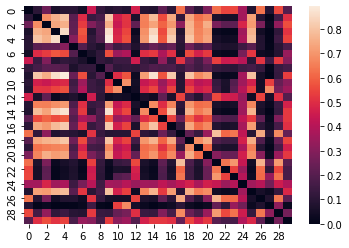

In [16]:
sns.heatmap(similarity_matrix)
plt.rcParams["figure.figsize"] = (10,7)
plt.show()

In [17]:
# Terrible attempt at a network graph

dt = [('len', float)]
A = similarity_matrix*10

A = A.view(dt)

G = nx.from_numpy_matrix(A)
G = nx.relabel_nodes(G, dict(zip(range(len(G.nodes())),string.ascii_uppercase)))    

G = nx.drawing.nx_agraph.to_agraph(G)

G.node_attr.update(color="red", style="filled")
G.edge_attr.update(color="blue", width="2.0")

G.draw('distances.png', format='png', prog='neato')

In [18]:
# Creating a smaller similarity matrix

similarity_matrix_20 = np.zeros((20,20))
for i in range(20):
    for k in range(20):
        similarity_matrix_20[i][k] = cosine_similarity(tfidf[i],tfidf[k]).flatten()
similarity_matrix_20 = similarity_matrix_20*10

for i in range(len(similarity_matrix_20)):
    for k in range(len(similarity_matrix_20)):
        if math.isclose(similarity_matrix_20[i][k],1):
            similarity_matrix_20[i][k] = 0

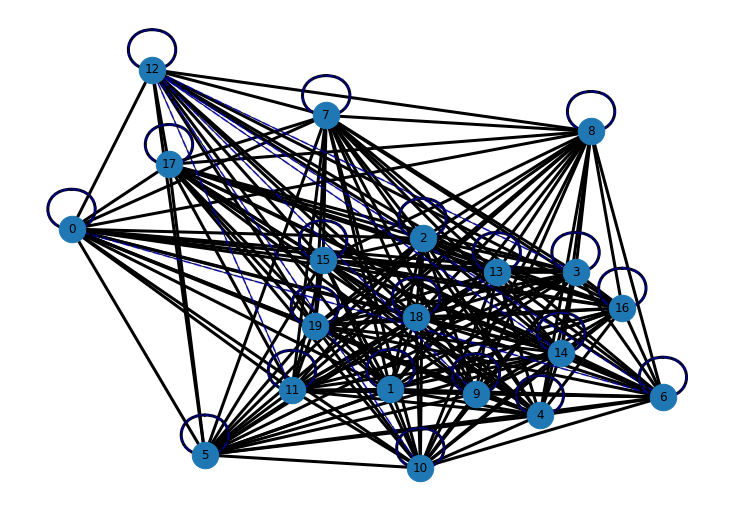

In [19]:
graph = nx.convert_matrix.from_numpy_array(similarity_matrix_20)
pos = nx.spring_layout(graph)
nx.draw(graph, pos, with_labels=True)
elarge = [(u, v) for (u, v, d) in graph.edges(data=True) if d["weight"] > 0.5]
esmall = [(u, v) for (u, v, d) in graph.edges(data=True) if d["weight"] <= 0.5]
nx.draw_networkx_nodes(graph, pos, node_size=700)
nx.draw_networkx_edges(graph, pos, edgelist=elarge, width=3)
nx.draw_networkx_edges(
    graph, pos, edgelist=esmall, width=2, alpha=0.5, edge_color="b", style="dashed"
)
plt.show()

In [2]:
stanza.download(lang='fr', model_dir='./stanza_models')

2021-12-01 10:44:55 INFO: Downloading default packages for language: fr (French)...
2021-12-01 11:34:40 INFO: Finished downloading models and saved to ../stanza_models.


In [20]:
nlp_fr = stanza.Pipeline(lang='fr',dir='./stanza_models')

2021-12-09 14:07:33 INFO: Loading these models for language: fr (French):
| Processor | Package |
-----------------------
| tokenize  | gsd     |
| mwt       | gsd     |
| pos       | gsd     |
| lemma     | gsd     |
| depparse  | gsd     |
| ner       | wikiner |

2021-12-09 14:07:33 INFO: Use device: cpu
2021-12-09 14:07:33 INFO: Loading: tokenize
2021-12-09 14:07:33 INFO: Loading: mwt
2021-12-09 14:07:33 INFO: Loading: pos
2021-12-09 14:07:34 INFO: Loading: lemma
2021-12-09 14:07:34 INFO: Loading: depparse
2021-12-09 14:07:34 INFO: Loading: ner
2021-12-09 14:07:35 INFO: Done loading processors!


In [4]:
stanza.download(lang='ru', model_dir='./stanza_models')

2021-12-01 13:34:00 INFO: Downloading default packages for language: ru (Russian)...
2021-12-01 13:37:37 INFO: Finished downloading models and saved to ./stanza_models.


In [21]:
corpus = pd.read_csv('7000 sentences Corpus with IDs.csv')

In [22]:
french = corpus['French']
french = french.dropna()
#french = french.to_numpy()
#french = french.tolist()
french = pd.DataFrame(french)
french['stanza'] = ''
french

,French,stanza
0,J'ai couru après lui en criant son nom mais il...,
1,Il est une heure de l'après-midi et nous somme...,
2,"Jean et Isabelle, vous devrez arriver à jeun a...",
3,Les étudiants doivent faire preuve de respect ...,
4,"Tiens! enlève donc ton pull, tu l'as mis à l'e...",
...,...,...
2993,Il est mort d'une septicémie,
2994,Les plantes grasses ont des feuilles charnues ...,
2995,"A vrai dire, je n'y avais pas pensé",
2996,N'oublie pas d'emporter le porte-monnaie,


In [23]:
french['stanza'] = french.apply(lambda x: nlp_fr(x["French"]), axis=1)
french

C:\Users\eleoc\AppData\Local\Programs\Python\Python39\lib\site-packages\stanza\models\common\beam.py:86: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  prevK = bestScoresId // numWords


,French,stanza
0,J'ai couru après lui en criant son nom mais il...,"[\n [\n {\n ""id"": 1,\n ""text"": ""..."
1,Il est une heure de l'après-midi et nous somme...,"[\n [\n {\n ""id"": 1,\n ""text"": ""..."
2,"Jean et Isabelle, vous devrez arriver à jeun a...","[\n [\n {\n ""id"": 1,\n ""text"": ""..."
3,Les étudiants doivent faire preuve de respect ...,"[\n [\n {\n ""id"": 1,\n ""text"": ""..."
4,"Tiens! enlève donc ton pull, tu l'as mis à l'e...","[\n [\n {\n ""id"": 1,\n ""text"": ""..."
...,...,...
2993,Il est mort d'une septicémie,"[\n [\n {\n ""id"": 1,\n ""text"": ""..."
2994,Les plantes grasses ont des feuilles charnues ...,"[\n [\n {\n ""id"": 1,\n ""text"": ""..."
2995,"A vrai dire, je n'y avais pas pensé","[\n [\n {\n ""id"": 1,\n ""text"": ""..."
2996,N'oublie pas d'emporter le porte-monnaie,"[\n [\n {\n ""id"": 1,\n ""text"": ""..."


In [24]:
french['word_list'] = ''

In [25]:
french['word_list'] = french.apply(lambda x: x["stanza"].to_dict()[0], axis=1)
french

,French,stanza,word_list
0,J'ai couru après lui en criant son nom mais il...,"[\n [\n {\n ""id"": 1,\n ""text"": ""...","[{'id': 1, 'text': 'J'', 'lemma': 'il', 'upos'..."
1,Il est une heure de l'après-midi et nous somme...,"[\n [\n {\n ""id"": 1,\n ""text"": ""...","[{'id': 1, 'text': 'Il', 'lemma': 'il', 'upos'..."
2,"Jean et Isabelle, vous devrez arriver à jeun a...","[\n [\n {\n ""id"": 1,\n ""text"": ""...","[{'id': 1, 'text': 'Jean', 'lemma': 'Jean', 'u..."
3,Les étudiants doivent faire preuve de respect ...,"[\n [\n {\n ""id"": 1,\n ""text"": ""...","[{'id': 1, 'text': 'Les', 'lemma': 'le', 'upos..."
4,"Tiens! enlève donc ton pull, tu l'as mis à l'e...","[\n [\n {\n ""id"": 1,\n ""text"": ""...","[{'id': 1, 'text': 'Tiens!', 'lemma': 'tien', ..."
...,...,...,...
2993,Il est mort d'une septicémie,"[\n [\n {\n ""id"": 1,\n ""text"": ""...","[{'id': 1, 'text': 'Il', 'lemma': 'il', 'upos'..."
2994,Les plantes grasses ont des feuilles charnues ...,"[\n [\n {\n ""id"": 1,\n ""text"": ""...","[{'id': 1, 'text': 'Les', 'lemma': 'le', 'upos..."
2995,"A vrai dire, je n'y avais pas pensé","[\n [\n {\n ""id"": 1,\n ""text"": ""...","[{'id': 1, 'text': 'A', 'lemma': 'à', 'upos': ..."
2996,N'oublie pas d'emporter le porte-monnaie,"[\n [\n {\n ""id"": 1,\n ""text"": ""...","[{'id': 1, 'text': 'N'', 'lemma': 'ne', 'upos'..."


In [86]:
french['verb'] = ''
french['lemma'] = ''
french['tense'] = ''

In [126]:
for i in range(len(french)+1):
    if i == 186:
        continue
    for k in range(len(french['word_list'][i])):
        try:
            if french['word_list'][i][k]['upos'] == 'VERB':
                temp_verb = french['word_list'][i][k]['text']
                temp_lemma = french['word_list'][i][k]['lemma']
                if 'Tense' in french['word_list'][i][k]['feats']:
                    temp_tense = re.search('Tense=(.*)Verb', french['word_list'][i][k]['feats']).group(1)[:-1]
                elif 'VerbForm' in french['word_list'][i][k]['feats']:
                    temp_tense = re.search('VerbForm=(.*)', french['word_list'][i][k]['feats']).group(1)
                break
        except KeyError:
            continue
    french['verb'][i] = temp_verb
    french['lemma'][i] = temp_lemma
    french['tense'][i] = temp_tense
french

,French,stanza,word_list,verb,lemma,tense
0,J'ai couru après lui en criant son nom mais il...,"[\n [\n {\n ""id"": 1,\n ""text"": ""...","[{'id': 1, 'text': 'J'', 'lemma': 'il', 'upos'...",couru,courir,Past
1,Il est une heure de l'après-midi et nous somme...,"[\n [\n {\n ""id"": 1,\n ""text"": ""...","[{'id': 1, 'text': 'Il', 'lemma': 'il', 'upos'...",couru,courir,Past
2,"Jean et Isabelle, vous devrez arriver à jeun a...","[\n [\n {\n ""id"": 1,\n ""text"": ""...","[{'id': 1, 'text': 'Jean', 'lemma': 'Jean', 'u...",devrez,devoir,Fut
3,Les étudiants doivent faire preuve de respect ...,"[\n [\n {\n ""id"": 1,\n ""text"": ""...","[{'id': 1, 'text': 'Les', 'lemma': 'le', 'upos...",doivent,devoir,Pres
4,"Tiens! enlève donc ton pull, tu l'as mis à l'e...","[\n [\n {\n ""id"": 1,\n ""text"": ""...","[{'id': 1, 'text': 'Tiens!', 'lemma': 'tien', ...",enlève,enlever,Pres
...,...,...,...,...,...,...
2993,Il est mort d'une septicémie,"[\n [\n {\n ""id"": 1,\n ""text"": ""...","[{'id': 1, 'text': 'Il', 'lemma': 'il', 'upos'...",mort,mourir,Past
2994,Les plantes grasses ont des feuilles charnues ...,"[\n [\n {\n ""id"": 1,\n ""text"": ""...","[{'id': 1, 'text': 'Les', 'lemma': 'le', 'upos...",ont,avoir,Pres
2995,"A vrai dire, je n'y avais pas pensé","[\n [\n {\n ""id"": 1,\n ""text"": ""...","[{'id': 1, 'text': 'A', 'lemma': 'à', 'upos': ...",dire,dire,Inf
2996,N'oublie pas d'emporter le porte-monnaie,"[\n [\n {\n ""id"": 1,\n ""text"": ""...","[{'id': 1, 'text': 'N'', 'lemma': 'ne', 'upos'...",oublie,oublier,Pres


In [204]:
french.drop(['stanza','word_list'],axis=1,inplace=True)

In [150]:
cg = Conjugator(lang='fr')

In [169]:
cg.conjugate('enlever')['moods']['subjonctif']['plus-que-parfait']

["que j'eusse enlevé",
 'que tu eusses enlevé',
 "qu'il eût enlevé",
 'que nous eussions enlevé',
 'que vous eussiez enlevé',
 "qu'ils eussent enlevé"]

In [180]:
temps_mode = ['indicatif','conditionnel','subjonctif']
temps_indicatif = ['présent','imparfait','futur-simple','passé-simple','passé-composé','plus-que-parfait','futur-antérieur','passé-antérieur']
temps_conditionnel = ['présent','passé']
temps_subjonctif = ['présent','imparfait','passé','plus-que-parfait']

In [191]:
french['dist_1'] = ''
french['dist_2'] = ''
french['dist_3'] = ''
french['dist_1_tense'] = ''
french['dist_2_tense'] = ''
french['dist_3_tense'] = ''
french['dist_1_pers'] = ''
french['dist_2_pers'] = ''
french['dist_3_pers'] = ''

In [252]:
for i in range(len(french)+1):
    if i == 186:
        continue
    lemma = french['lemma'][i]
    try:
        cg.conjugate(lemma)
    except ConjugatorError:
        continue
    for k in range(3):
        mode = random.randint(0,2)
        if mode == 0:
            temps = random.randint(0,7)
            temps_array = temps_indicatif
        elif mode == 1:
            temps = random.randint(0,1)
            temps_array = temps_conditionnel
        else:
            temps = random.randint(0,3)
            temps_array = temps_subjonctif
        if len(cg.conjugate(lemma)['moods'][temps_mode[mode]][temps_array[temps]]) == 0:
            continue
        elif len(cg.conjugate(lemma)['moods'][temps_mode[mode]][temps_array[temps]]) < 6:
            personne = random.randint(0,len(cg.conjugate(lemma)['moods'][temps_mode[mode]][temps_array[temps]])-1)
            personne_out = 0
        else:
            personne = random.randint(0,5)
            personne_out = personne+1
        french['dist_'+str(k+1)][i] = cg.conjugate(lemma)['moods'][temps_mode[mode]][temps_array[temps]][personne]
        french['dist_'+str(k+1)+'_tense'][i] = str(temps_mode[mode])+' '+str(temps_array[temps])
        french['dist_'+str(k+1)+'_pers'][i] = personne_out
french

C:\Users\eleoc\AppData\Local\Temp/ipykernel_21716/179622722.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  french['dist_'+str(k+1)][i] = cg.conjugate(lemma)['moods'][temps_mode[mode]][temps_array[temps]][personne]
C:\Users\eleoc\AppData\Local\Temp/ipykernel_21716/179622722.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  french['dist_'+str(k+1)+'_tense'][i] = str(temps_mode[mode])+' '+str(temps_array[temps])
C:\Users\eleoc\AppData\Local\Temp/ipykernel_21716/179622722.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https:/

,French,verb,lemma,tense,dist_1,dist_2,dist_3,dist_1_tense,dist_2_tense,dist_3_tense,dist_1_pers,dist_2_pers,dist_3_pers
0,J'ai couru après lui en criant son nom mais il...,couru,courir,Past,que je coure,que j'eusse couru,il aurait couru,subjonctif présent,subjonctif plus-que-parfait,conditionnel passé,1,1,3
1,Il est une heure de l'après-midi et nous somme...,couru,courir,Past,vous aurez couru,il aurait couru,qu'il coure,indicatif futur-antérieur,conditionnel passé,subjonctif présent,5,3,3
2,"Jean et Isabelle, vous devrez arriver à jeun a...",devrez,devoir,Fut,que vous dussiez,ils doivent,ils devraient,subjonctif imparfait,indicatif présent,conditionnel présent,5,6,6
3,Les étudiants doivent faire preuve de respect ...,doivent,devoir,Pres,que je dusse,que vous dussiez,ils auraient dû,subjonctif imparfait,subjonctif imparfait,conditionnel passé,1,5,6
4,"Tiens! enlève donc ton pull, tu l'as mis à l'e...",enlève,enlever,Pres,que vous enleviez,nous avions enlevé,vous enleviez,subjonctif présent,indicatif plus-que-parfait,indicatif imparfait,5,4,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2993,Il est mort d'une septicémie,mort,mourir,Past,ils sont morts,qu'il soit mort,qu'ils meurent,indicatif passé-composé,subjonctif passé,subjonctif présent,6,3,6
2994,Les plantes grasses ont des feuilles charnues ...,ont,avoir,Pres,que tu aies,ils auraient,tu aurais eu,subjonctif présent,conditionnel présent,conditionnel passé,2,6,2
2995,"A vrai dire, je n'y avais pas pensé",dire,dire,Inf,tu dirais,qu'ils aient dit,vous aurez dit,conditionnel présent,subjonctif passé,indicatif futur-antérieur,2,6,5
2996,N'oublie pas d'emporter le porte-monnaie,oublie,oublier,Pres,que j'oublie,vous aviez oublié,il aura oublié,subjonctif présent,indicatif plus-que-parfait,indicatif futur-antérieur,1,5,3


In [254]:
french.to_csv(r'french.csv',encoding='utf-8')